Total Revenue: $794,492.43
Total Profit: $218,937.99
Average Order Value: $662.08
Number of Orders: 1200


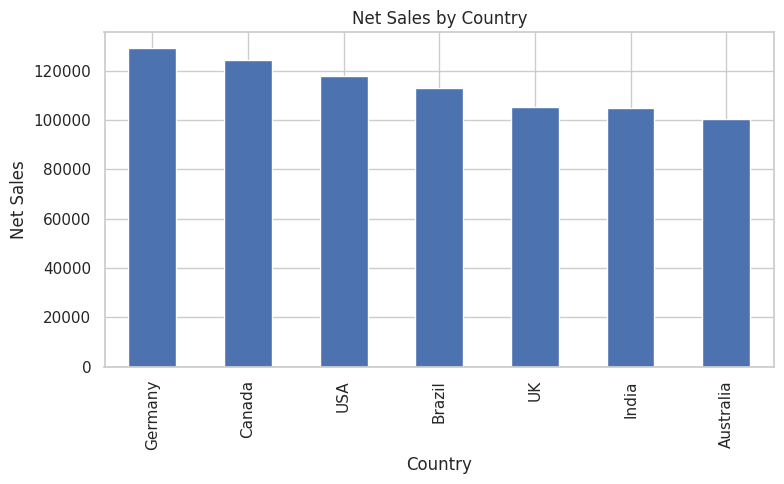

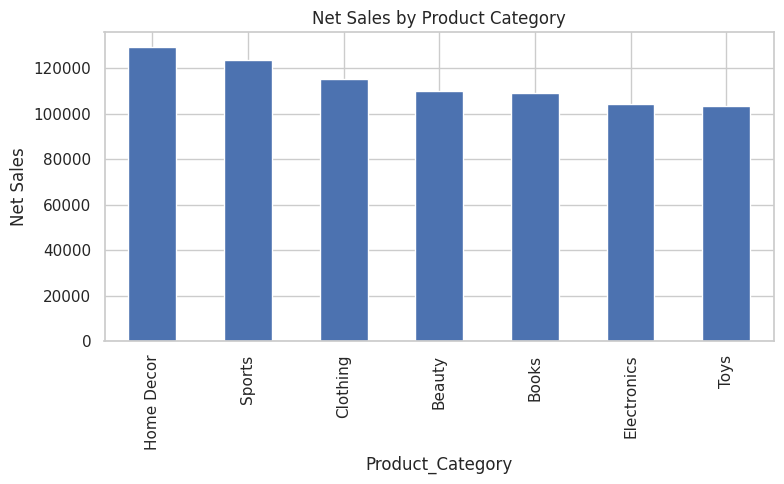

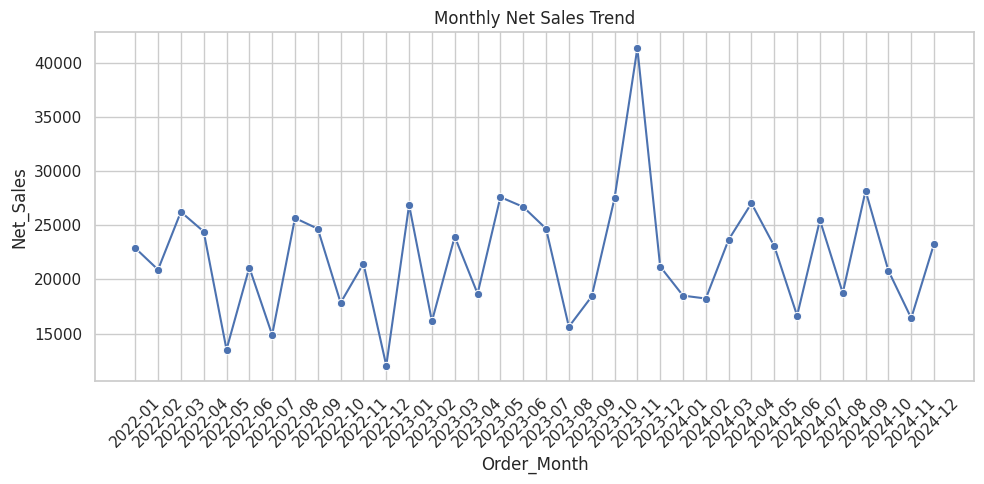

Late delivery rate: 51.00%


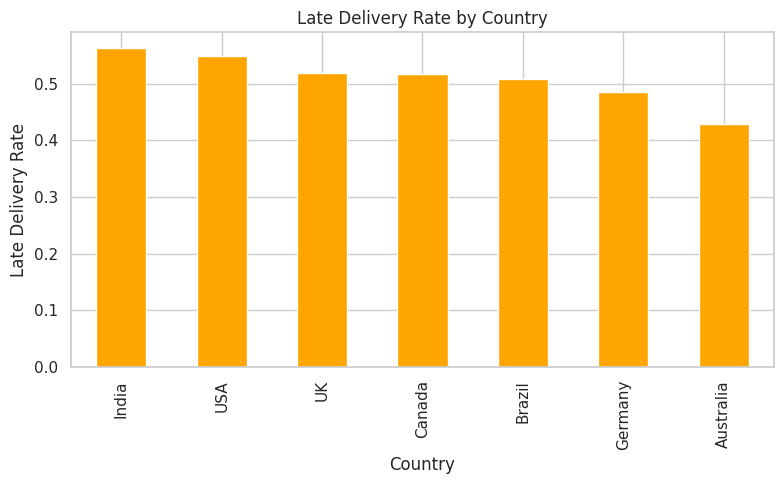

Accuracy: 0.47333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.50      0.48       147
           1       0.48      0.44      0.46       153

    accuracy                           0.47       300
   macro avg       0.47      0.47      0.47       300
weighted avg       0.47      0.47      0.47       300



In [2]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
# Load dataset
df = pd.read_csv('ecommerce_sales_dataset.csv', parse_dates=['Order_Date'])
df.head()
# Feature engineering: create revenue, order month, late delivery flag
df['Order_Month'] = df['Order_Date'].dt.to_period('M').astype(str)
df['Sales'] = (df['Quantity'] * df['Unit_Price']).round(2)
df['Discount_Amount'] = ((df['Sales'] * df['Discount(%)'])/100).round(2)
df['Net_Sales'] = (df['Sales'] - df['Discount_Amount']).round(2)
df['Profit'] = df['Profit'].round(2)
# Define late delivery as delivery time > 7 days (example)
df['Late_Delivery'] = (df['Delivery_Time(Days)'] > 7).astype(int)
df.head()
# Key KPIs
total_revenue = df['Net_Sales'].sum()
total_profit = df['Profit'].sum()
avg_order_value = df['Net_Sales'].mean()
orders_count = df.shape[0]
print(f'Total Revenue: ${total_revenue:,.2f}')
print(f'Total Profit: ${total_profit:,.2f}')
print(f'Average Order Value: ${avg_order_value:,.2f}')
print(f'Number of Orders: {orders_count}')
# Sales by Country and Product Category
sales_country = df.groupby('Country')['Net_Sales'].sum().sort_values(ascending=False)
sales_category = df.groupby('Product_Category')['Net_Sales'].sum().sort_values(ascending=False)

# Plot: Revenue by Country
plt.figure(figsize=(8,5))
sales_country.plot(kind='bar')
plt.title('Net Sales by Country')
plt.ylabel('Net Sales')
plt.tight_layout()
plt.show()

# Plot: Revenue by Product Category
plt.figure(figsize=(8,5))
sales_category.plot(kind='bar')
plt.title('Net Sales by Product Category')
plt.ylabel('Net Sales')
plt.tight_layout()
plt.show()
# Monthly sales trend
monthly_sales = df.groupby('Order_Month')['Net_Sales'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='Order_Month', y='Net_Sales', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Net Sales Trend')
plt.tight_layout()
plt.show()
# RFM Segmentation (simplified)
import datetime as dt
snapshot_date = df['Order_Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (snapshot_date - x.max()).days,
    'Order_ID': 'count',
    'Net_Sales': 'sum'
}).reset_index()
rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']
# Score RFM
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()
# Delivery performance summary
late_rate = df['Late_Delivery'].mean()
print(f'Late delivery rate: {late_rate:.2%}')
late_by_country = df.groupby('Country')['Late_Delivery'].mean().sort_values(ascending=False)
late_by_category = df.groupby('Product_Category')['Late_Delivery'].mean().sort_values(ascending=False)

# Plot: Late delivery rate by Country
plt.figure(figsize=(8,5))
late_by_country.plot(kind='bar', color='orange')
plt.title('Late Delivery Rate by Country')
plt.ylabel('Late Delivery Rate')
plt.tight_layout()
plt.show()
# Prepare dataset for classification (Late Delivery prediction)
features = ['Quantity', 'Unit_Price', 'Discount(%)', 'Net_Sales', 'Profit']
X = df[features]
y = df['Late_Delivery']

# Train-test split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
# Save sample plots to project folder for README use
plt.figure(figsize=(8,5))
sales_country.plot(kind='bar')
plt.title('Net Sales by Country')
plt.ylabel('Net Sales')
plt.tight_layout()
plt.savefig('net_sales_by_country.png')
plt.close()
# ... same for category and late delivery
